In [1]:
import pandas as pd
data = pd.read_csv('training_data.csv')
data.describe()
test_well = data[data['Well Name'] == 'SHANKLE']
data = data[data['Well Name'] != 'SHANKLE']
#test_well = data[data['Well Name'] == 'SHRIMPLIN']
#data = data[data['Well Name'] != 'SHRIMPLIN']

In [2]:
features = ['GR', 'ILD_log10', 'DeltaPHI','PHIND','PE','NM_M', 'RELPOS']
feature_vectors = data[features]
facies_labels = data['Facies']
from sklearn.preprocessing import label_binarize
# Binarize the output
y = label_binarize(facies_labels, classes=[1,2,3,4,5,6,7,8,9])
n_classes = y.shape[1]

In [3]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(feature_vectors)
scaled_features = scaler.transform(feature_vectors) #ndarray now. 

In [4]:
from sklearn.cross_validation import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(scaled_features, y,test_size=0.05, random_state=42)

C:\Users\jchen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
from sklearn.metrics import classification_report,roc_auc_score
target_names = ['SS', 'CSiS', 'FSiS', 'SiSh','MS', 'WS', 'D','PS', 'BS']

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.multiclass import OneVsRestClassifier
clf = OneVsRestClassifier(AdaBoostClassifier())
model=clf.fit(X_train, y_train)
y_score = model.decision_function(X_cv) 

In [7]:
y_cv_pred = clf.predict(X_cv) 
print(classification_report(y_cv, y_cv_pred,target_names=target_names))

             precision    recall  f1-score   support

         SS       1.00      0.56      0.72        16
       CSiS       0.62      0.69      0.66        29
       FSiS       0.48      0.71      0.57        14
       SiSh       0.60      0.43      0.50         7
         MS       0.86      0.33      0.48        18
         WS       0.43      0.13      0.20        23
          D       1.00      0.67      0.80         3
         PS       0.76      0.57      0.65        23
         BS       0.71      0.71      0.71         7

avg / total       0.68      0.51      0.55       140



In [8]:
y_pred = clf.predict(X_cv)
print(classification_report(y_cv, y_pred,target_names=target_names))
y_score.shape
#roc_auc_score(y_cv,y_score)

             precision    recall  f1-score   support

         SS       1.00      0.56      0.72        16
       CSiS       0.62      0.69      0.66        29
       FSiS       0.48      0.71      0.57        14
       SiSh       0.60      0.43      0.50         7
         MS       0.86      0.33      0.48        18
         WS       0.43      0.13      0.20        23
          D       1.00      0.67      0.80         3
         PS       0.76      0.57      0.65        23
         BS       0.71      0.71      0.71         7

avg / total       0.68      0.51      0.55       140



(140, 9)

In [9]:
y_cv.shape

(140, 9)

In [10]:
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_cv[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_cv.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [11]:
import matplotlib.pyplot as plt
plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

<Figure size 640x480 with 1 Axes>

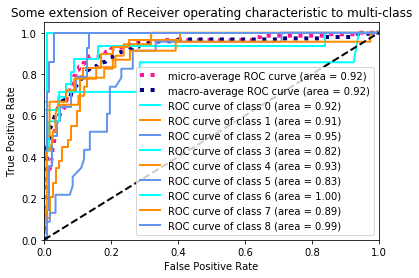

In [15]:
# Compute macro-average ROC curve and ROC area
import numpy as np
from scipy import interp
from itertools import cycle
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()